## Project Overview

This project uses data science methods to find optimal solutions for sending outreach sequence emails. 
Through data analysis and machine learning models, we can determine strong indicators of whether or not a prospect will engage with an email. With these important factors, the company can improve the efficiency and effect of the sequences.

## Project Outline

Part 1: Data Exploration
> Part 1.1: Understand raw dataset
<br>Part 1.2: Data Cleaning
<br>Part 1.3: Exploratory Data Analysis

Part 2: Feature Enigeering
> Part 2.1: Drop irrelavant features
<br>Part 2.2: Create new features
<br>Part 2.3: Time related features
<br>Part 2.4: Feature correlation

Part 3: Building Models
> Part 3.1: Explore models
<br>Part 3.2: Model evaluation

Part 4: Summary
    

## Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [67]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
# import cPickle
plt.style.use("ggplot")
%matplotlib inline
import matplotlib.pyplot as plt

In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import chi2,f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix, roc_curve,precision_score,recall_score,auc,precision_recall_curve

In [7]:
# pd.set_option('display.max_columns', None)
df = pd.read_csv('./sequence-mailings.csv',error_bad_lines=False)

b'Skipping line 100296: expected 44 fields, saw 47\nSkipping line 100360: expected 44 fields, saw 47\nSkipping line 100366: expected 44 fields, saw 47\nSkipping line 100367: expected 44 fields, saw 47\nSkipping line 100448: expected 44 fields, saw 47\nSkipping line 100449: expected 44 fields, saw 47\nSkipping line 100535: expected 44 fields, saw 45\nSkipping line 100702: expected 44 fields, saw 45\nSkipping line 100898: expected 44 fields, saw 45\nSkipping line 100928: expected 44 fields, saw 45\nSkipping line 101560: expected 44 fields, saw 47\nSkipping line 101563: expected 44 fields, saw 47\nSkipping line 102367: expected 44 fields, saw 47\nSkipping line 102369: expected 44 fields, saw 47\nSkipping line 102967: expected 44 fields, saw 47\nSkipping line 103006: expected 44 fields, saw 47\nSkipping line 104103: expected 44 fields, saw 47\nSkipping line 104139: expected 44 fields, saw 47\nSkipping line 104742: expected 44 fields, saw 47\nSkipping line 104776: expected 44 fields, saw 47

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
# unique value overview
for column in df.columns:
    uniques = df[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

### Part 1.2: Data cleaning

#### Handle data formatting error

In [8]:
# date format
df['delivered_at'] = pd.to_datetime(df['delivered_at'])
df['thread_replied_at'] = pd.to_datetime(df['thread_replied_at'])
df['replied_at'] = pd.to_datetime(df['replied_at'])
df['opened_at'] = pd.to_datetime(df['opened_at'])
df['clicked_at'] = pd.to_datetime(df['clicked_at'])
df['prospect_dob'] = pd.to_datetime(df['prospect_dob'])
df['prospect_opted_out'] = pd.to_datetime(df['prospect_opted_out'])

#### Handle data integrity, typos and anomalies

In [9]:
# company tier: some of company tier are represented as number(company size), some should be normalized
def company_tier(tier):
    if tier == '201-1000':
        t = 'Mid-Market'
    elif tier == 'SMB':
        t = 'Small Business'
    else:
        return tier
    return t

In [10]:
for data in [df]:
    data['company_tier'] = data['company_tier'].apply(company_tier)

In [11]:
# city locality: There're some typos in city names, also some city names should be normalized
def correct_city_locality(city):
    if pd.isnull(city):
        return city
    if city == 'Adddison':
        c = 'Addison'
    if city == 'Bejing':
        c = 'Beijing'
    if city == 'Washington' or city == 'Washington D.C. Metro Area' or city == 'Washington, D.C.' or city == 'Washington, DC':
        c = 'Washington, D.C.'
    if city.split(" ")[-1] == 'Area':
        c = city.split(" ")[0]
    else:
        return city
    return c

In [12]:
for data in [df]:
    data['company_locality'] = data['company_locality'].apply(correct_city_locality)

#### Correct and normalize ill-formed texts

In [13]:
# prospect_time_zone
def time_zone(time):
    if time == 'America/New_York':
        t = 'EST'
    elif time == 'America/Chicago' or time =='America/Denvor' or time =='America/Indiana/Indianapolis' or time =='America/Mexico_City' or time =='America/Monterrey' or time =='America/Regina':
        t = 'CST'
    elif time == 'America/Los_Angeles':
        t = 'PST'
    elif time == 'America/Phoenix':
        t = 'MDT'
    else:
        return time
    return t


In [14]:
for data in [df]:
    data['prospect_time_zone'] = data['prospect_time_zone'].apply(time_zone)
# df['prospect_time_zone']

In [15]:
#prospect_city
def correct_city(city):
    if city == '0' or city == '8700' or city == '.':
        c = None
    # represents the US states
    else:
        return city
    return c

In [16]:
for data in [df]:
    data['prospect_city'] = data['prospect_city'].apply(correct_city)
df.head(50)

,id,message_id,parent_message_id,to_domain,from,is_thread_reply,subject_customized,body_customized,subject_length,body_length,...,prospect_opted_out,persona,company_name,company_size,industry,website,company_locality,company_tier,sequence_order,tags
0,6756,<541c38a863c25_5ad93fae6971f12c_1_67@app.mail>,NaN,birchbox.com,manny@outreach.io,1,0,0,33.0,850.0,...,NaT,Recruiting,NaN,NaN,NaN,NaN,NaN,NaN,1,"birchbox,recruiting,sampler app"
1,6757,<541c530d33a3e_38983f994f693278_1_e4@worker.mail>,NaN,birchbox.com,manny@outreach.io,1,0,0,NaN,249.0,...,NaT,Recruiting,NaN,NaN,NaN,NaN,NaN,NaN,2,"birchbox,recruiting,sampler app"
2,6762,<541cc6885b944_6f803f8c38c7514c_1_63@app.mail>,NaN,customerlobby.com,manny@outreach.io,1,0,0,19.0,1012.0,...,NaT,Sales Leadership,Customer Lobby,51.0,Internet,customerlobby.com,Berkeley,Mid-Market,1,"01222015,1:11242014,angel,Batch 1 (Nov '14),Co..."
3,6763,<541cc68876a28_6f803f8c38c7514c_1_3b@app.mail>,NaN,doubledutch.me,manny@outreach.io,1,0,0,19.0,1012.0,...,NaT,Sales Leadership,DoubleDutch,51.0,Computer Software,www.doubledutch.me,San Francisco,Mid-Market,1,"01222015,angel,Colleague,Colleague562,double d..."
4,6764,<541cc6888fc74_6f803f8c38c7514c_1_35@app.mail>,NaN,maprtech.com,manny@outreach.io,1,0,0,19.0,1012.0,...,2014-12-12 15:10:37,Sales Leadership,MapR Technologies,NaN,NaN,NaN,NaN,NaN,1,"1:11242014,outbound"
5,6765,<541cc688a5c46_6f803f8c38c7514c_1_b1@app.mail>,NaN,opendns.com,manny@outreach.io,1,0,0,19.0,1012.0,...,NaT,Sales Leadership,OpenDNS - now a part of Cisco,NaN,Internet,opendns.com,San Francisco,Mid-Market,1,"1:11242014,Batch 1 (Nov '14),ChrisL,outbound"
6,6767,<541cc688d000c_6f803f8c38c7514c_1_d3@app.mail>,NaN,mashery.com,manny@outreach.io,1,0,0,19.0,1012.0,...,2015-02-06 02:40:12,Sales Leadership,Mashery,NaN,NaN,NaN,NaN,NaN,1,"1:11242014,outbound"
7,6768,<541cc688e5de9_6f803f8c38c7514c_1_61@app.mail>,NaN,yahoo.com,manny@outreach.io,1,0,0,19.0,1012.0,...,NaT,Sales Leadership,Rocket Lawyer,NaN,Internet,rocketlawyer.com,San Francisco,Mid-Market,1,"1:11242014,Batch 1 (Nov '14),FB VISIT,FHTA,out..."
8,6769,<541cc689818b_6f803f8c38c7514c_1_b2@app.mail>,NaN,netskope.com,manny@outreach.io,1,0,0,19.0,1012.0,...,2017-07-21 08:38:19,Sales Leadership,Netskope,51.0,Computer Software,netskope.com,Los Altos,Mid-Market,1,"01222015,Batch 1 (Nov '14),Colleague,Colleague..."
9,6770,<541cc6891dcd9_6f803f8c38c7514c_1_2@app.mail>,NaN,mixamo.com,manny@outreach.io,1,0,0,19.0,1012.0,...,NaT,Sales Leadership,Wowzer,NaN,NaN,NaN,NaN,NaN,1,"1:11242014,outbound"


In [17]:
#prospect_country
def correct_country(country):
    if country == 'United States' or country == 'United State' or country == 'US' or country == 'USA':
        c = 'U.S.'
    # represents the US states
    elif country == 'AZ' or country =='CA' or country =='FL' or country =='GA' or country =='IL' or country =='IN'\
    or country =='MA' or country =='MI' or country =='MN' or country =='MO'or country =='NY' or country =='OH'\
    or country =='OR' or country =='PA' or country =='WA':
        c = 'U.S.'
    elif country == 'United Kingdom' or 'UK':
        c = 'U.K.'
    elif country == '0':
        c = None
    else:
        return country
    return c

In [18]:
for data in [df]:
    data['prospect_country'] = data['prospect_country'].apply(correct_country)
# df.head(50)

In [19]:
#website
def correct_website(site):
#     print (type(site))
    if pd.isnull(site):
        return site
    if str(site).startswith('http://'):
        s = site.split("//")[-1]
        if str(s).startswith('www.') == False:
            s = 'www.'+s  
    elif str(site).startswith('www.') == False:
        s = 'www.'+site   
    else:
        return site

    return s


In [20]:
for data in [df]: 
    data['website'] = data['website'].apply(correct_website)
    data['prospect_website'] = data['prospect_website'].apply(correct_website)

#### Data Deduplication

In [21]:
df=df.drop_duplicates(keep='first')
df.reset_index(drop=True, inplace=True)
df.shape

(1023256, 44)

Chi2 test and f test

In [25]:
#create a new column, reply or not -> 0/1
df['reply']= np.where(df['replied_at'].isnull(),0,1)

In [78]:
resp_lb_encoder = LabelEncoder()
cnty_lb_encoder = LabelEncoder()

X = df.copy()
y = resp_lb_encoder.fit_transform(X.reply)
del X["reply"]

feat_names = ["deliver_h","sequence_step_id","sequence_id","template_id","subject_customized" ]
X = X.loc[:,feat_names]
# X["from"] = cnty_lb_encoder.fit_transform(X.from)
# X["persona"] = cnty_lb_encoder.fit_transform(X.persona)
# X["company_tier"] = cnty_lb_encoder.fit_transform(X.company_tier)

chi2scores,_ = chi2(X,y)
fscores,_ = f_classif(X,y)

feat_scores = pd.DataFrame({"chi2scores":chi2scores,"fscores":fscores},index=feat_names)

In [79]:
feat_scores.sort_values(by='chi2scores',ascending=False)

,chi2scores,fscores
sequence_step_id,4.006346e+07,12174.515410
template_id,3.907289e+07,11735.835509
sequence_id,7.704328e+06,13458.884828
deliver_h,2.913225e+03,851.904073
subject_customized,3.935440e+02,398.100435


In [80]:
feat_scores.sort_values(by="fscores",ascending=False)

,chi2scores,fscores
sequence_id,7.704328e+06,13458.884828
sequence_step_id,4.006346e+07,12174.515410
template_id,3.907289e+07,11735.835509
deliver_h,2.913225e+03,851.904073
subject_customized,3.935440e+02,398.100435


from the test result, we can know that,

important features: previous purchase counts, user's country, email's version (personal or general)
not so important features maybe include: weekday, email's text (short or long), hour to send the email

### Part 1.3: Exploratory Data Analysis

#### Part 1.3.1 missing data

In [22]:
# null information
df.isnull().sum()

id                            0
message_id                    0
parent_message_id        290930
to_domain                     0
from                          0
is_thread_reply               0
subject_customized            0
body_customized               0
subject_length           568935
body_length               10410
delivered_at                  0
thread_replied_at        989568
replied_at               992119
track_links                   8
track_opens                   8
includes_link           1023127
opened_at                745829
clicked_at              1020122
mailbox_id                    0
template_id                   0
sequence_id                   0
sequence_step_id              0
sequence_template_id        530
sequence_state_id             0
prospect_id                   0
prospect_first_name           2
prospect_time_zone       510234
prospect_gender         1023137
prospect_dob            1021676
prospect_occupation       89076
prospect_city            423029
prospect

In [23]:
# missing value overview
rows_list = []
for column in df.columns:
    total = len(df[column])
    count_nan = total - df[column].count()
    missing_proportion = count_nan/total
    if missing_proportion > 0.00:
        dict1 = {}
        dict1['Feature']=column
        dict1['missing_proportion']=missing_proportion
        rows_list.append(dict1)
m_df = pd.DataFrame(rows_list)           
# m_df             

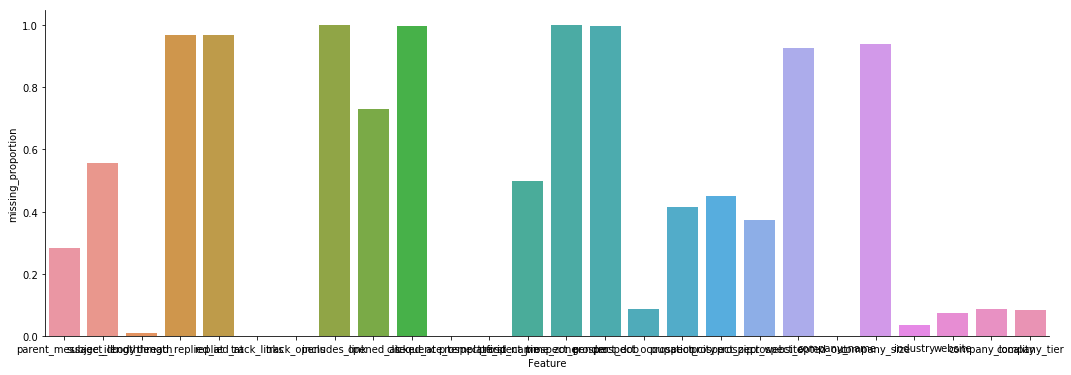

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

sns.barplot(x='Feature', y='missing_proportion', data=m_df, ax=ax)
sns.despine()

There are 27 features that contain missing values. I divide them into the following types:
1. Missing not at random (nonignorable): 
    parent_message_id, thread_replied_at, replied_at, includes_link, opened_at, clicked_at, prospect_opt_out, track_links, track_opens
2. Missing at random:
    subject_length, body_length, sequence_template_id, prospect_first_name, prospect_occupation, company_name,
    industry, website, company_locality, company_tier
3. Too many missing values (> 40%):
    company_size, prospect_gender, prospect_dob, prospect_time_zone, prospect_website, prospect_city,prospect_zip,prospect_country


In [26]:
df.drop(columns=['replied_at'],inplace=True)

### Part 1.3.2 Data analysis

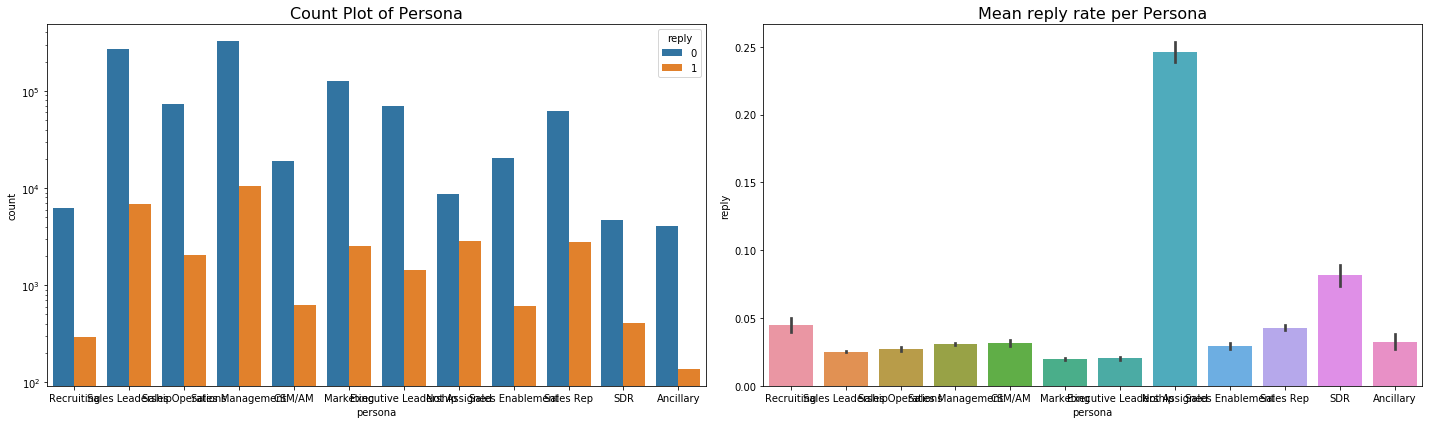

In [27]:
#prospect_occupation
# Visualization of different countries
grouped = df[['prospect_occupation', 'reply']].groupby('prospect_occupation').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.countplot(x='persona', hue='reply', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Persona', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='persona', y='reply', data=df, ax=ax[1]);
ax[1].set_title('Mean reply rate per Persona', fontsize=16)
plt.tight_layout()
plt.show()

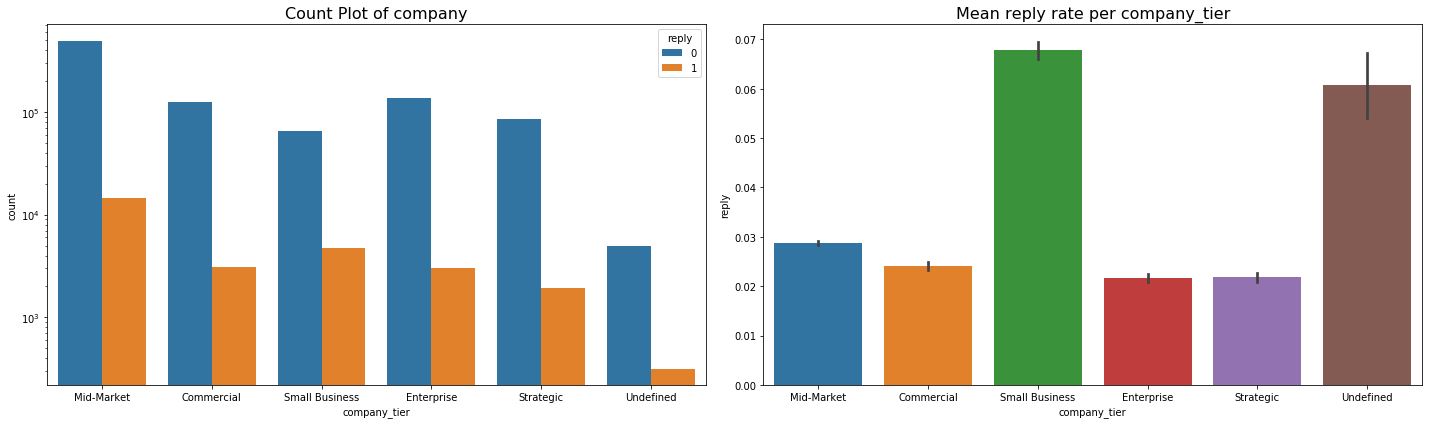

In [28]:
#company tier
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.countplot(x='company_tier', hue='reply', data=df, ax=ax[0])
ax[0].set_title('Count Plot of company', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='company_tier', y='reply', data=df, ax=ax[1]);
ax[1].set_title('Mean reply rate per company_tier', fontsize=16)
plt.tight_layout()
plt.show()

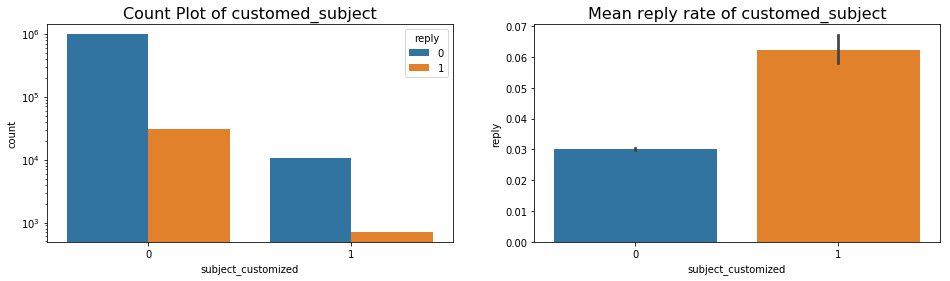

In [29]:
#subject_customized
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.countplot(x='subject_customized', hue='reply', data=df, ax=ax[0])
ax[0].set_title('Count Plot of customed_subject', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='subject_customized', y='reply', data=df, ax=ax[1]);
ax[1].set_title('Mean reply rate of customed_subject', fontsize=16)
# plt.tight_layout()
plt.show()

1. For different persona group, the reply rate is diffrent from the barchart. Although there are many prospects not assigned persona, but among all other persona, SDR group has the highest reply rate. This makes sense because sales development rep (SDR) is sales rep that solely focuses on outbound prospecting, so sending emails to right people is important.
2. For different company group, the reply rate is different. Small business have the highest reply rate according to the barchart. It makes sense because small business is more likely to focus on growing their business. 
3. Whether the subject is customed also affects the reply rate, it makes sense because prospects are willing to see an email specially customized for them, rather than an automatedly outreaching one.

# Part 2: Feature Engineering

### Part 2.1: Drop irrelavant features

In [30]:
#For those who has over 40% missing values, I completely drop the variable
#company_size, prospect_gender, prospect_dob, prospect_time_zone, prospect_website, prospect_city,prospect_zip,prospect_country 
df.drop(columns=['company_size','prospect_gender','prospect_dob','prospect_time_zone','prospect_website','prospect_city','prospect_zip','prospect_country','tags'],inplace=True)

In [31]:
#drop irrelavant features
#id, message_id, prospect_id
df.drop(columns=['id', 'message_id', 'prospect_id'],inplace=True)

### Part 2.2: Create new features

In [32]:
#subject length is null because there's: median
#body length: impute missing value using median
subject_length_median = df.subject_length.median()
df.loc[df['subject_length'].isnull(), 'subject_length' ] = subject_length_median

body_length_median = df.body_length.median()
df.loc[df['body_length'].isnull(), 'body_length' ] = body_length_median

In [33]:
#parent_message_id -> if have parent message
#parent_message_id is null, which means the message don't have parent message, use 0 to replace null
df['have_parent_message'] = np.where(df['parent_message_id'].isnull(),0,1)
df.drop(columns=['parent_message_id'],inplace=True)

In [34]:
#prospect_opted_out is null, which means the prospect has opted out, use 0 to replace null
df['prospect_opted_out'] = np.where(df['prospect_opted_out'].isnull(),0,1)
df.drop(columns=['prospect_opted_out'],inplace=True)

In [35]:
#track_links, track_opens
df.track_links.fillna(-1, inplace = True)
df.track_opens.fillna(-1, inplace = True)

### Part 2.3: Build time related features

In [36]:
# get the time lag(minute) between open time and deliver time
df['deliver_to_open_time_lag']=(df['opened_at']-df['delivered_at']).astype('timedelta64[m]')

# get the time lag(minute) between thread reply time and deliver time
df['deliver_to_thread_reply_time_lag']=(df['thread_replied_at']-df['delivered_at']).astype('timedelta64[m]')

In [37]:
# delivered_at
# divide into year, month, day and hour
df['deliver_y']=df['delivered_at'].dt.year
df['deliver_m']=df['delivered_at'].dt.month
df['deliver_d']=df['delivered_at'].dt.day
df['deliver_h']=df['delivered_at'].dt.hour
df.drop(columns=['delivered_at'],inplace=True)

In [38]:
#thread_replied_at
#divide into year, month, day and hour
df['thread_y']=df['thread_replied_at'].dt.year
df['thread_m']=df['thread_replied_at'].dt.month
df['thread_d']=df['thread_replied_at'].dt.day
df['thread_h']=df['thread_replied_at'].dt.hour
df.drop(columns=['thread_replied_at'],inplace=True)

In [39]:
#opened_at
#divide into year, month, day and hour
df['opened_y']=df['opened_at'].dt.year
df['opened_m']=df['opened_at'].dt.month
df['opened_d']=df['opened_at'].dt.day
df['opened_h']=df['opened_at'].dt.hour
df.drop(columns=['opened_at'],inplace=True)

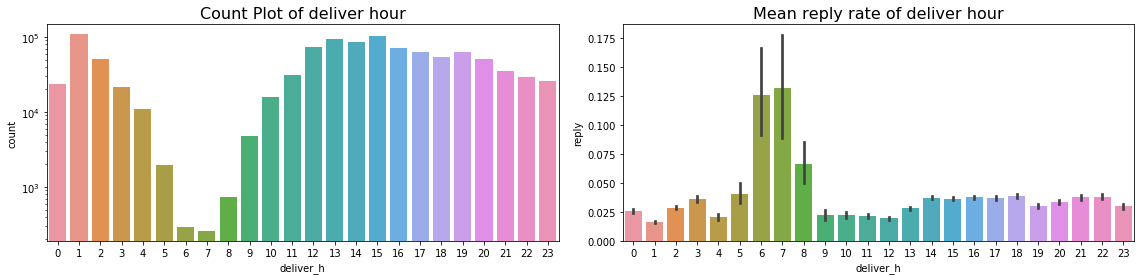

In [40]:
#deliver_hour
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.countplot(x='deliver_h', data=df, ax=ax[0])
ax[0].set_title('Count Plot of deliver hour', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='deliver_h', y='reply', data=df, ax=ax[1]);
ax[1].set_title('Mean reply rate of deliver hour', fontsize=16)
plt.tight_layout()
plt.show()

From the barplot, we can see the reply rate is high when emails are sent during 6-8am. This may be because, people usually start to work in the morning, the emails sent in the early morning are tend to appear in top of the mailbox and easy to be seen and replied.

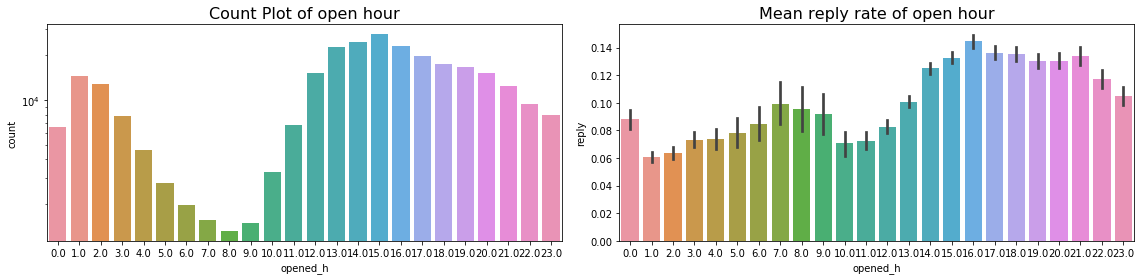

In [41]:
#open_hour
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.countplot(x='opened_h', data=df, ax=ax[0])
ax[0].set_title('Count Plot of open hour', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='opened_h', y='reply', data=df, ax=ax[1]);
ax[1].set_title('Mean reply rate of open hour', fontsize=16)
plt.tight_layout()
plt.show()

From the barplot, we can see the reply rate is higher when emails are opened in the afternoon.

### Part 2.4: Feature correlation 

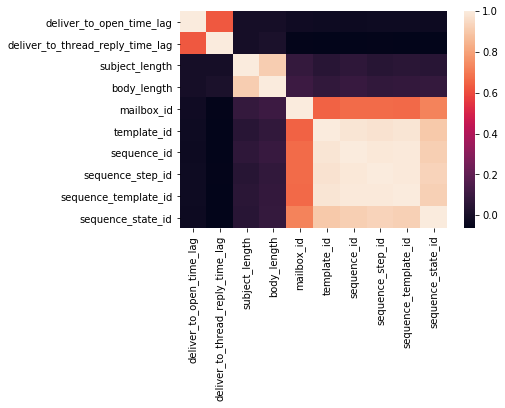

In [42]:
corr = df[['deliver_to_open_time_lag', 'deliver_to_thread_reply_time_lag', 'subject_length',
                    'body_length', 'mailbox_id','template_id','sequence_id', 'sequence_step_id','sequence_template_id',
'sequence_state_id']].corr()
sns.heatmap(corr)

# Part 3: Build models

In [43]:
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
# from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [44]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,5 days 22 hours 43 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_chenling_zrr5ns
H2O cluster total nodes:,1
H2O cluster free memory:,1.486 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [45]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(df)

h2o_df['reply'] = h2o_df['reply'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,to_domain,from,is_thread_reply,subject_customized,body_customized,subject_length,body_length,track_links,track_opens,includes_link,clicked_at,mailbox_id,template_id,sequence_id,sequence_step_id,sequence_template_id,sequence_state_id,prospect_first_name,prospect_occupation,persona,company_name,industry,website,company_locality,company_tier,sequence_order,reply,have_parent_message,deliver_to_open_time_lag,deliver_to_thread_reply_time_lag,deliver_y,deliver_m,deliver_d,deliver_h,thread_y,thread_m,thread_d,thread_h,opened_y,opened_m,opened_d,opened_h
type,enum,enum,int,int,int,int,int,int,int,enum,time,int,int,int,int,int,int,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,int,enum,enum,int,int,int,int,enum,enum,enum,enum,enum,enum,enum,enum
mins,,,0.0,0.0,0.0,1.0,12.0,-1.0,-1.0,,1411173265000.0,15.0,61.0,60.0,151.0,211.0,1110.0,,,,,,,,,1.0,,0.0,,,2014.0,1.0,1.0,0.0,,,,,,,,
mean,,,0.9889372747386773,0.01106272526132268,0.00012606815889669838,43.06454689735512,1013.3051171945239,0.11962500097727255,0.9999745909137108,,1450788452009.2527,131.8245277819041,20202.73556861626,3118.7360709343507,13785.648321632121,13312.246066884001,264496.6500465181,,,,,,,,,5.618060387625384,,0.7156820971487096,,,2016.3622993659455,6.325543168083061,15.82161648697882,12.862820252214496,,,,,,,,
maxs,,,1.0,1.0,1.0,270.0,27347.0,1.0,1.0,,1511893530000.0,475.0,43238.0,6626.0,37029.0,31838.0,562712.0,,,,,,,,,49.0,,1.0,,,2017.0,12.0,31.0,23.0,,,,,,,,
sigma,,,0.10459613789629582,0.10459613789629581,0.011227305505042175,50.52010289850162,1079.3402281751337,0.324546759983761,0.006406624819120973,,27799606210.883224,85.13260138659857,8248.252373671698,1344.8983710368655,6775.324305814703,5977.246304986232,152204.3231766278,,,,,,,,,4.217924202258464,,0.4510891617256529,,,0.758161195431663,3.4014697909790494,8.619194475774593,6.634990056505531,,,,,,,,
zeros,,,11320,1011936,1023127,0,0,900833,10,,0,0,0,0,0,0,0,,,,,,,,,0,,290930,,,0,0,0,23489,,,,,,,,
missing,0,0,0,0,0,0,0,0,0,0,1020122,0,0,0,0,530,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,birchbox.com,manny@outreach.io,1.0,0.0,0.0,33.0,850.0,0.0,1.0,nan,,15.0,238.0,60.0,151.0,211.0,1110.0,Anthony,nan,Recruiting,nan,nan,nan,nan,nan,1.0,0,0.0,0.0,nan,2014.0,9.0,19.0,16.0,nan,nan,nan,nan,2014.0,9.0,19.0,16.0
1,birchbox.com,manny@outreach.io,1.0,0.0,0.0,31.0,249.0,1.0,1.0,nan,,15.0,229.0,60.0,152.0,212.0,1110.0,Anthony,nan,Recruiting,nan,nan,nan,nan,nan,2.0,0,0.0,0.0,nan,2014.0,9.0,22.0,16.0,nan,nan,nan,nan,2014.0,9.0,22.0,16.0
2,customerlobby.com,manny@outreach.io,1.0,0.0,0.0,19.0,1012.0,1.0,1.0,nan,,15.0,242.0,61.0,155.0,215.0,1113.0,Wayne,Internet,Sales Leadership,Customer Lobby,Internet,www.customerlobby.com,Berkeley,Mid-Market,1.0,0,0.0,nan,nan,2014.0,9.0,20.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan


In [46]:
# Split into 80% training and 20% test dataset
strat_split = h2o_df['reply'].stratified_split(test_frac=0.2, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

print(train.shape, test.shape)

(818605, 42) (204651, 42)


In [47]:
feature = list(df.columns).remove('reply')
target = 'reply'

### Random Forest

In [62]:
# Build random forest model
# model = H2ORandomForestEstimator(balance_classes=True, ntrees=50, max_depth=10, 
#                                  mtries=-1, seed=42, score_each_iteration=True,)
# model.train(x=feature, y=target, training_frame=train)

H2O Random Forest:
1. balance_classes=True, among two classes: reply and no reply, num of negative class is extremely greater than positive class, I set the parameter to True to deal with the imbalanced class.

2. ntrees=50, max_depth=10

3. Random Forest will impute missing values. Some missing values are already preprocessed.

4. H2O will do one-hot-encoding to categorical features.

Boosted tree models are immune to multicollinearity by nature, because when they split trees, the tree will choose one of the perfectly correlated feature 

In [ ]:
# model.varimp_plot()

In [ ]:
# Feature importance
# importance = model.varimp(use_pandas=True)

# fig, ax = plt.subplots(figsize=(10, 8))
# sns.barplot(x='scaled_importance', y='variable', data=importance)
# plt.show()

According to feature importance, Thread_replied_at feature has extremely high feature importance. It's probably because the feature causality. If there's already replied email in the thread, in most cases prospects will reply to follow up. However, we may want to focus more on other features. So I drop this 'thread_replied_at' related feature. 

 time lag bewtween deliver time and open time, time lag bewtween deliver time and thread reply time play important roles in the email reply.
which means the time the email deliver, time open, time thread open matters.

In [49]:
h2o_df=h2o_df.drop(['thread_y','thread_m','thread_d','thread_h','deliver_to_thread_reply_time_lag'])

In [50]:
# Split into 80% training and 20% test dataset
strat_split = h2o_df['reply'].stratified_split(test_frac=0.2, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

print(train.shape, test.shape)

(818605, 37) (204651, 37)


In [51]:
feature = list(h2o_df.columns).remove('reply')
target = 'reply'

In [60]:
print(train)

to_domain,from,is_thread_reply,subject_customized,body_customized,subject_length,body_length,track_links,track_opens,includes_link,clicked_at,mailbox_id,template_id,sequence_id,sequence_step_id,sequence_template_id,sequence_state_id,prospect_first_name,prospect_occupation,persona,company_name,industry,website,company_locality,company_tier,sequence_order,reply,have_parent_message,deliver_to_open_time_lag,deliver_y,deliver_m,deliver_d,deliver_h,opened_y,opened_m,opened_d,opened_h
birchbox.com,manny@outreach.io,1,0,0,33,850,0,1,nan,,15,238,60,151,211,1110,Anthony,nan,Recruiting,nan,nan,nan,nan,nan,1,0,0,0,2014,9,19,16,2014,9,19,16
customerlobby.com,manny@outreach.io,1,0,0,19,1012,1,1,nan,,15,242,61,155,215,1113,Wayne,Internet,Sales Leadership,Customer Lobby,Internet,www.customerlobby.com,Berkeley,Mid-Market,1,0,0,nan,2014,9,20,0,nan,nan,nan,nan
doubledutch.me,manny@outreach.io,1,0,0,19,1012,1,1,nan,,15,242,61,155,215,1114,Russ,Computer Software,Sales Leadership,DoubleDutch,Computer Software,www.doubledutch.me,San Francisco,Mid-Market,1,0,0,55,2014,9,20,0,2014,9,20,1
maprtech.com,manny@outreach.io,1,0,0,19,1012,1,1,nan,,15,242,61,155,215,1115,John,nan,Sales Leadership,MapR Technologies,nan,nan,nan,nan,1,0,0,4,2014,9,20,0,2014,9,20,0
mashery.com,manny@outreach.io,1,0,0,19,1012,1,1,nan,,15,242,61,155,215,1118,Rodque,nan,Sales Leadership,Mashery,nan,nan,nan,nan,1,0,0,nan,2014,9,20,0,nan,nan,nan,nan
yahoo.com,manny@outreach.io,1,0,0,19,1012,1,1,nan,,15,242,61,155,215,1119,Paul,Internet,Sales Leadership,Rocket Lawyer,Internet,www.rocketlawyer.com,San Francisco,Mid-Market,1,0,0,64,2014,9,20,0,2014,9,20,1
netskope.com,manny@outreach.io,1,0,0,19,1012,1,1,nan,,15,242,61,155,215,1120,Paul,Computer Software,Sales Leadership,Netskope,Computer Software,www.netskope.com,Los Altos,Mid-Market,1,0,0,1,2014,9,20,0,2014,9,20,0
mixamo.com,manny@outreach.io,1,0,0,19,1012,1,1,nan,,15,242,61,155,215,1121,Mike,nan,Sales Leadership,Wowzer,nan,nan,nan,nan,1,0,0,2374,2014,9,20,0,2014,9,21,16
financialforce.com,manny@outreach.io,1,0,0,19,1012,1,1,nan,,15,242,61,155,215,1122,Adrian,Computer Software,Sales Leadership,FinancialForce.com,Computer Software,www.FinancialForce.com,San Francisco,Commercial,1,0,0,182,2014,9,20,0,2014,9,20,3
thismoment.com,manny@outreach.io,1,0,0,19,1012,1,1,nan,,15,242,61,155,215,1123,Brian,nan,Sales Leadership,ThisMoment,nan,nan,nan,nan,1,0,0,122,2014,9,20,0,2014,9,20,2


In [ ]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=50, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True,)
model.train(x=feature, y=target, training_frame=train)

In [ ]:
model.varimp_plot()

From the feature importance chart, we can see the time when the email is opened is important.
Given that the open time matters, there are other indicators: from which email address, industry, prospect occupation, sequence id and sequence step id.

#### Plot ROC curve and choose better probability threshold

since the data is highly imbalanced (positive examples is only 3% of the total examples), if using default probability threshold (0.5), the model just classify every example as negative, so we need to plot the ROC curve and choose a better probability threshold.

In [ ]:
#split validation set
strat_split = h2o_df['reply'].stratified_split(test_frac=0.2, seed=42)
validation = h2o_df[strat_split == 'test']
model_v = H2ORandomForestEstimator(balance_classes=True, ntrees=50, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True,)
model_v.train(x=feature, y=target, training_frame=train)

In [ ]:
validation_true = validation.as_data_frame()['reply'].values
validation_pred = model_v.predict(validation).as_data_frame()['p1'].values

validation_fpr, validation_tpr, _ = roc_curve(validation_true, validation_pred)
validation_auc = np.round(auc(validation_fpr, validation_tpr), 3)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(validation_fpr, validation_tpr, label='Validation AUC: ' + str(validation_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [ ]:
d={}
d['FPR'],d['TPR'],d['Threshold'] = roc_curve(validation_true, validation_pred)
roc_results = pd.DataFrame(d)
roc_results.loc[(roc_results.TPR > 0.6) & (roc_results.TPR < 0.65),:].head()

In [ ]:
# Make predictions
# train_true = train.as_data_frame()['reply'].values
test_true = test.as_data_frame()['reply'].values
# train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

### XGBoost

I also tried XGBoost, it took long time to run the model. The performance is slightly better than random forest model but compared to time consumtion it has no big advantage.

In [ ]:
# H2OXGBoostEstimator
# model2= H2OXGBoostEstimator(max_depth=10, nfolds=10, ntrees=50, score_each_iteration=True)
# model2.train(x=feature, y=target, training_frame=train)

In [ ]:
# train_pred2 = model2.predict(train).as_data_frame()['p1'].values
# test_pred2 = model2.predict(test).as_data_frame()['p1'].values

### Model evaluation

In [ ]:
# Classification report
print('Classification report for Random Forest')
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.1042).astype(int)))

In [ ]:
# Classification report
print('Classification report for XGBoost')
print(classification_report(y_true=test_true, y_pred=(test_pred2 > 0.1042).astype(int)))

Based on the classification report, we can see the precision and recall are high when predicting negtive class, which is pretty good that we save time and resources on a lot of bad sequence emails. Also the model have accpetable recall on positive outcomes.

In [ ]:
# Shutdown h2o instance
h2o.cluster().shutdown()

you'll investigate one particular algorithm with an increasing 'max_depth' parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R2, the coefficient of determination.

### Logistic regression

In [ ]:
X = dataframe.loc[:,('country', 'age', 'new_user', 'source', 'total_pages_visited')]

# OHE those categorical features
X = pd.get_dummies(X)

In [ ]:
y = dataframe.converted
y.mean()

from y's mean(), we know that, target value is very imbalanced, which reminds us should not use plain 'accurancy' as the metric to judge a classifier is good or not

then we need to split the whole dataset into 'training' dataset and 'test' dataset

In [ ]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.333)

In [ ]:
ytrain.mean(),ytest.mean()

since both ytrain.mean() and ytest.mean() are similar to y.mean(), we can say, the splitting process doesn't import any bias

In [ ]:
## since the problem cares giving explanation on each factor
## it seems it would be better to use L1 penalty
## however, L1 penalty doesn't produce a sparse coeffecient, but AUC is much lower
## so I switch back to use L2 penalty
lrcv = LogisticRegressionCV(Cs = np.logspace(-3,3,7),
                            dual=False,
                            scoring='roc_auc',
                            max_iter=1000,
                            n_jobs=-1,
                            verbose=1)
lrcv.fit(Xtrain,ytrain)

In [ ]:

ytest_predict = lrcv.predict(Xtest)
print classification_report(y_true=ytest,y_pred=ytest_predict)

In [ ]:
feat_importances = pd.DataFrame({"name":Xtrain.columns,"coef":lrcv.coef_[0]})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

### Decision tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)
export_graphviz(dt,feature_names=X.columns,class_names=['NotFraud','Fraud'],
                proportion=True,leaves_parallel=True,filled=True)

From above plot, we focus on two leaf-nodes

the blue leaf node indicates, if 'interval_after_signup' is <=69 seconds, which means the customer purchases immediatelly after signup, then there is very high probability that this transaction is fraud.
the leaf-node with positive ratio=23% (the second node from right), if the purchase is from a device shared by 2~4 users, then there is above-normal probability that the transaction is fraud.

in this case, because normally this "Fraud Detection Model" is often used in a pre-screening step, whose result will be further investigated by expert, so

if 'Not Fraud' is classified as 'Fraud', human expert can still have method to fix the problem
but if 'Fraud' is classified as 'Not Fraud', the company will lose money directly.

so in this case, "false negative" cost much higher, so we should choose a relatively smaller threshold.

## Part 4: Summary

Sending sequence emails may depend on factors from several aspects: to whom, when and how.
<br> According to data analysis, these behavior will probably get better prospect engagement. 
1. sending sequence email to small business, SDR (sales development rep)
2. set the deliver time at early morning (6-8am)
3. customize email subject and content 

I have the hypothesis: successful emails may be influenced by subject, content, the sender and receiver.
When running models, wen can see the feature importance, to some extent it proves my hypothesis. The sender, receiver occupation and industry, sequence id play important roles.

Besides, we can apply some machine learning models to try to predict the reply probability. 
In this notebook, I implement the Random Forest model and XGBoost. The model has good ability to predict negative outcomes. Knowing we have a great email response would be nice, but avoiding a bad sequence email is much more valuable, saving large amount of ineffective emails.

Based on the model built previously, we can send email to selected prospects that are predicted to have higher probability to reply. The new strategy will be: only send email to users which my model predicts positive.
If we want to further test it, we can conduct A/B test to see if the built model can actually help improve the reply-rate.